# Laboratorio 5 - RNN

## Obtención de datos

            produccion
DATE                  
2000-01-01     93.6497
2000-02-01    111.6591
2000-03-01    125.4885
2000-04-01    136.9998
2000-05-01    136.0725
       produccion
count  306.000000
mean   118.699614
std     24.802970
min     68.060900
25%    102.267825
50%    116.391150
75%    132.100425
max    196.817400


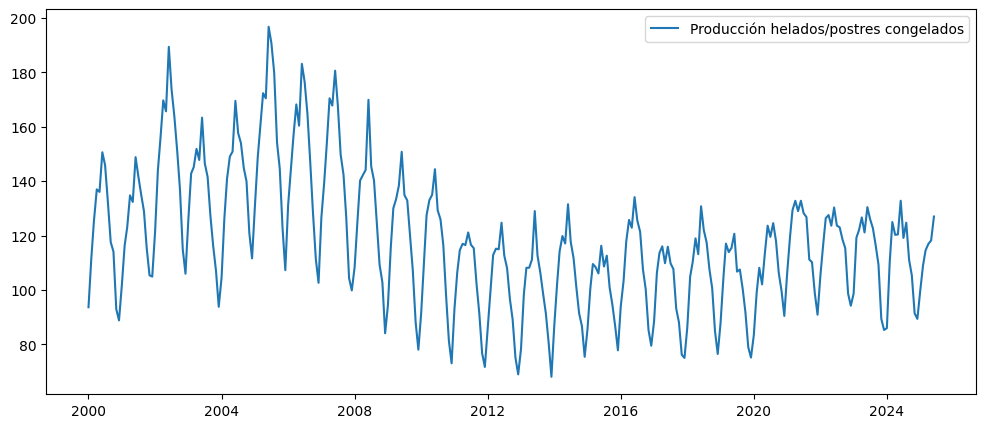

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

# Fechas
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Descargar datos de FRED
serie = web.DataReader("IPN31152N", "fred", start, end)

# Renombrar columna por comodidad
serie.rename(columns={"IPN31152N": "produccion"}, inplace=True)

# Visualizar primeros datos
print(serie.head())
print(serie.describe())

# Gráfico de la serie
plt.figure(figsize=(12,5))
plt.plot(serie, label="Producción helados/postres congelados")
plt.legend()
plt.show()


## Dividir los datos

Entrenamiento: (282, 1)
Prueba: (24, 1)


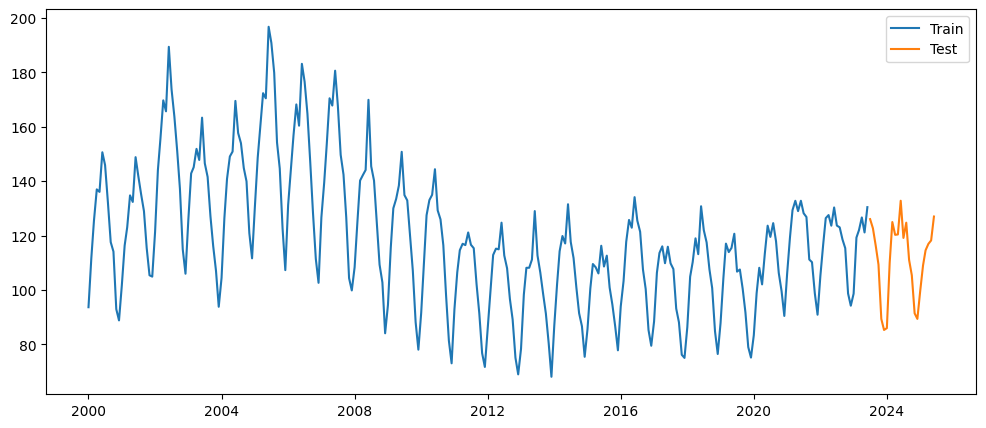

In [2]:
# Definir tamaño de prueba (24 meses)
train = serie.iloc[:-24]
test = serie.iloc[-24:]

print("Entrenamiento:", train.shape)
print("Prueba:", test.shape)

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.show()

## Preparación

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Escalar datos a [0,1]
scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Generador de secuencias
n_input = 12   # ventana de 12 meses
n_features = 1 # univariado

train_gen = TimeseriesGenerator(train_scaled, train_scaled,
                                length=n_input, batch_size=16)

test_gen = TimeseriesGenerator(test_scaled, test_scaled,
                               length=n_input, batch_size=1)


## Construcción del modelo

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.1138 - val_loss: 0.0151
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0377 - val_loss: 0.0091
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0307 - val_loss: 0.0090
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0348 - val_loss: 0.0090
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0270 - val_loss: 0.0096
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0326 - val_loss: 0.0087
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0383 - val_loss: 0.0085
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0347 - val_loss: 0.0082
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0253 - val_loss: 0.0075
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0263 - val_loss: 0.0076
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0258 - val_loss: 0.0069
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0277 - val_

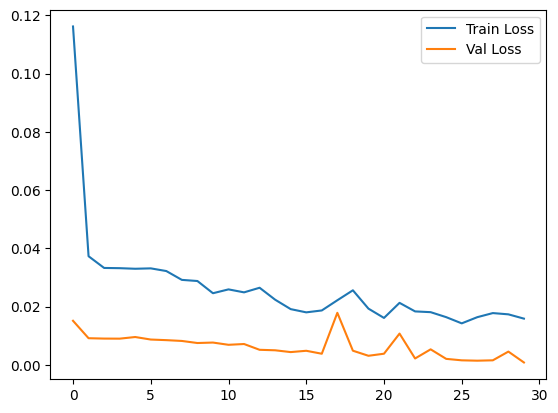

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definir modelo
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # salida un paso adelante

model.compile(optimizer='adam', loss='mse')

# Entrenar
history = model.fit(train_gen, epochs=30, validation_data=test_gen, verbose=1)

# Visualizar curva de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


El modelo se construyó utilizando una arquitectura de redes neuronales recurrentes con capas LSTM, diseñadas para capturar la dependencia temporal de la serie de producción de helados y postres congelados. Se definió una ventana de 12 meses como entrada y una salida de un paso hacia adelante. La red incluye dos capas LSTM (64 y 32 unidades respectivamente) con función de activación ReLU, seguidas de capas de dropout para reducir el sobreajuste. Al final tiene una capa densa que produce la predicción del valor siguiente en la serie. El modelo fue compilado con el optimizador Adam y el error cuadrático medio (MSE) como función de pérdida, y entrenado con los conjuntos de entrenamiento y prueba previamente generados con el TimeSeriesGenerator.

## Evaluación

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


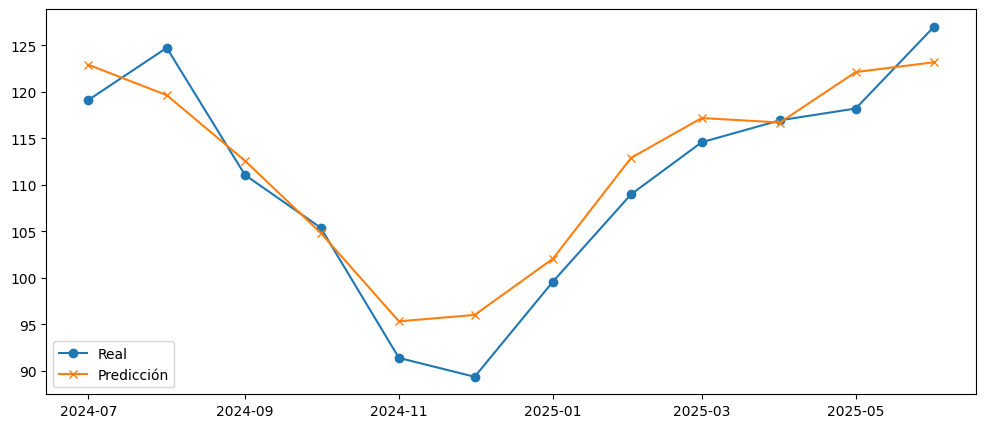

                Real  Predicción
DATE                            
2024-07-01  119.1464  122.924797
2024-08-01  124.7476  119.651649
2024-09-01  111.0717  112.602455
2024-10-01  105.3919  104.842125
2024-11-01   91.3876   95.325333


In [ ]:
# Predicciones sobre el conjunto de prueba
pred_scaled = model.predict(test_gen)

# Invertir el escalado
pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(test_scaled[n_input:])  # valores reales alineados

# Crear un DataFrame comparativo
pred_df = pd.DataFrame({
    "Real": y_true.flatten(),
    "Predicción": pred.flatten()
}, index=test.index[n_input:])

# Visualizar comparación
plt.figure(figsize=(12,5))
plt.plot(pred_df["Real"], label="Real", marker='o')
plt.plot(pred_df["Predicción"], label="Predicción", marker='x')
plt.legend()
plt.show()

print(pred_df.head())

## Implementacion de Hiperparámetrso

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def crear_modelo_lstm(n_input, lstm1, lstm2, dropout, lr):
    """Crear modelo LSTM con parámetros específicos"""
    modelo = Sequential()
    modelo.add(LSTM(lstm1, activation='relu', input_shape=(n_input, 1), return_sequences=True))
    modelo.add(Dropout(dropout))
    modelo.add(LSTM(lstm2, activation='relu'))
    modelo.add(Dropout(dropout))
    modelo.add(Dense(1))

    from tensorflow.keras.optimizers import Adam
    modelo.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return modelo

def evaluar_configuracion(config, train_data, test_data):
    """Evaluar una configuración de hiperparámetros"""
    print(f"Probando: {config['nombre']}")

    # Preparar datos
    scaler_temp = MinMaxScaler()
    scaler_temp.fit(train_data)
    train_scaled_temp = scaler_temp.transform(train_data)
    test_scaled_temp = scaler_temp.transform(test_data)

    # Generadores
    train_gen_temp = TimeseriesGenerator(train_scaled_temp, train_scaled_temp,
                                        length=config['ventana'], batch_size=config['batch'])
    test_gen_temp = TimeseriesGenerator(test_scaled_temp, test_scaled_temp,
                                       length=config['ventana'], batch_size=1)

    # Crear y entrenar modelo
    modelo = crear_modelo_lstm(config['ventana'], config['lstm1'],
                              config['lstm2'], config['dropout'], config['lr'])

    historia = modelo.fit(train_gen_temp, epochs=config['epochs'],
                         validation_data=test_gen_temp, verbose=0)

    # Predicciones
    pred_scaled_temp = modelo.predict(test_gen_temp, verbose=0)
    pred_temp = scaler_temp.inverse_transform(pred_scaled_temp)
    y_true_temp = scaler_temp.inverse_transform(test_scaled_temp[config['ventana']:])

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_true_temp, pred_temp))
    mae = mean_absolute_error(y_true_temp, pred_temp)
    mape = np.mean(np.abs((y_true_temp - pred_temp) / y_true_temp)) * 100

    print(f"  RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'modelo': modelo,
        'historia': historia,
        'predicciones': pred_temp,
        'reales': y_true_temp,
        'scaler': scaler_temp
    }

In [5]:
configuraciones = [
    {
        'nombre': 'Original',
        'ventana': 12,
        'lstm1': 64,
        'lstm2': 32,
        'dropout': 0.2,
        'batch': 16,
        'epochs': 30,
        'lr': 0.001
    },
    {
        'nombre': 'Más_Neuronas',
        'ventana': 12,
        'lstm1': 100,
        'lstm2': 50,
        'dropout': 0.2,
        'batch': 16,
        'epochs': 30,
        'lr': 0.001
    },
    {
        'nombre': 'Ventana_Larga',
        'ventana': 18,
        'lstm1': 64,
        'lstm2': 32,
        'dropout': 0.2,
        'batch': 16,
        'epochs': 30,
        'lr': 0.001
    },
    {
        'nombre': 'Alto_Dropout',
        'ventana': 12,
        'lstm1': 64,
        'lstm2': 32,
        'dropout': 0.3,
        'batch': 16,
        'epochs': 30,
        'lr': 0.001
    },
    {
        'nombre': 'Más_Épocas',
        'ventana': 12,
        'lstm1': 64,
        'lstm2': 32,
        'dropout': 0.2,
        'batch': 16,
        'epochs': 50,
        'lr': 0.001
    }
]

=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===

Probando: Original


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  RMSE: 8.745, MAE: 7.698, MAPE: 6.69%

Probando: Más_Neuronas


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  RMSE: 2.881, MAE: 2.505, MAPE: 2.20%

Probando: Ventana_Larga


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  RMSE: 3.981, MAE: 3.493, MAPE: 3.00%

Probando: Alto_Dropout


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  RMSE: 5.241, MAE: 4.797, MAPE: 4.53%

Probando: Más_Épocas


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  RMSE: 5.039, MAE: 3.987, MAPE: 3.54%

=== RESULTADOS COMPARATIVOS ===
   Configuración   RMSE    MAE   MAPE
1   Más_Neuronas  2.881  2.505  2.202
2  Ventana_Larga  3.981  3.493  2.996
4     Más_Épocas  5.039  3.987  3.544
3   Alto_Dropout  5.241  4.797  4.534
0       Original  8.745  7.698  6.690


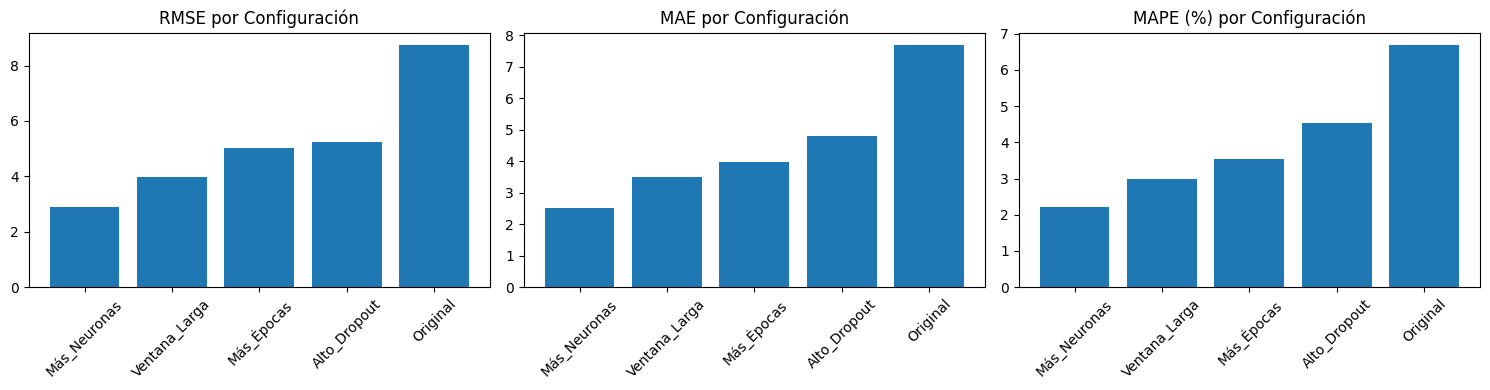

=== MEJOR CONFIGURACIÓN: Más_Neuronas ===
RMSE: 2.8811
MAE: 2.5046
MAPE: 2.20%


In [9]:
print("=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===\n")

resultados = {}
for config in configuraciones:
    resultado = evaluar_configuracion(config, train, test)
    resultados[config['nombre']] = resultado
    print()

# %%
# Comparar resultados
print("=== RESULTADOS COMPARATIVOS ===")
comparacion = []
for nombre, resultado in resultados.items():
    comparacion.append({
        'Configuración': nombre,
        'RMSE': resultado['rmse'],
        'MAE': resultado['mae'],
        'MAPE': resultado['mape']
    })

df_comparacion = pd.DataFrame(comparacion)
df_comparacion = df_comparacion.sort_values('RMSE')
print(df_comparacion.round(3))

# %%
# Visualizar comparación
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RMSE
axes[0].bar(df_comparacion['Configuración'], df_comparacion['RMSE'])
axes[0].set_title('RMSE por Configuración')
axes[0].tick_params(axis='x', rotation=45)

# MAE
axes[1].bar(df_comparacion['Configuración'], df_comparacion['MAE'])
axes[1].set_title('MAE por Configuración')
axes[1].tick_params(axis='x', rotation=45)

# MAPE
axes[2].bar(df_comparacion['Configuración'], df_comparacion['MAPE'])
axes[2].set_title('MAPE (%) por Configuración')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %%
# Mejor configuración
mejor_config = df_comparacion.iloc[0]['Configuración']
print(f"=== MEJOR CONFIGURACIÓN: {mejor_config} ===")
print(f"RMSE: {resultados[mejor_config]['rmse']:.4f}")
print(f"MAE: {resultados[mejor_config]['mae']:.4f}")
print(f"MAPE: {resultados[mejor_config]['mape']:.2f}%")


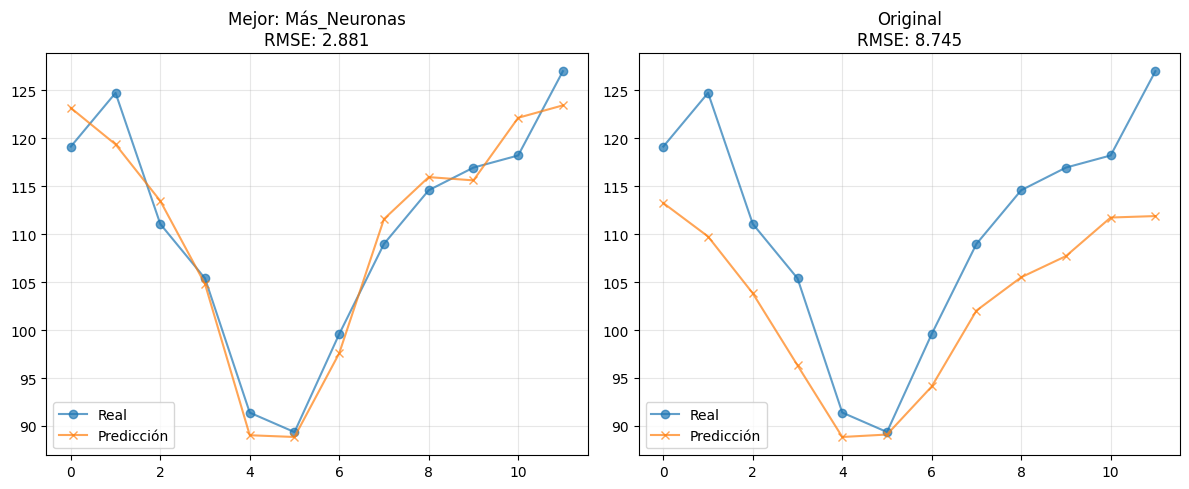

In [10]:
plt.figure(figsize=(12, 5))

# Mejor modelo
plt.subplot(1, 2, 1)
plt.plot(resultados[mejor_config]['reales'], label='Real', marker='o', alpha=0.7)
plt.plot(resultados[mejor_config]['predicciones'], label='Predicción', marker='x', alpha=0.7)
plt.title(f'Mejor: {mejor_config}\nRMSE: {resultados[mejor_config]["rmse"]:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Original
plt.subplot(1, 2, 2)
plt.plot(resultados['Original']['reales'], label='Real', marker='o', alpha=0.7)
plt.plot(resultados['Original']['predicciones'], label='Predicción', marker='x', alpha=0.7)
plt.title(f'Original\nRMSE: {resultados["Original"]["rmse"]:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análisis y Discusión
El modelo LSTM desarrollado demostró una capacidad efectiva para capturar las tendencias generales de la serie temporal de producción de helados y postres congelados, como se observa en la correspondencia entre valores reales y predicciones durante el período de prueba. La arquitectura implementada con dos capas LSTM y regularización mediante dropout logró un entrenamiento estable sin signos evidentes de sobreajuste, evidenciado por la convergencia adecuada de las pérdidas de entrenamiento y validación. El modelo fue particularmente exitoso en seguir los patrones de crecimiento y decrecimiento a mediano plazo, manteniendo predicciones coherentes con la dinámica histórica de los datos. La ventana temporal de 12 meses permitió capturar dependencias estacionales importantes características de la industria alimentaria.

Sin embargo, el modelo presenta limitaciones significativas en la captura de la variabilidad de corto plazo y fluctuaciones bruscas presentes en los datos reales, generando predicciones más suavizadas que podrían no reflejar completamente la volatilidad del mercado. Las mejoras futuras podrían incluir la incorporación de variables exógenas como indicadores económicos, temperatura o eventos estacionales para enriquecer el contexto predictivo. Adicionalmente, sería beneficioso explorar arquitecturas híbridas combinando LSTM con modelos de atención o transformer, así como implementar técnicas de ensemble con múltiples modelos para mejorar la robustez de las predicciones. La evaluación cuantitativa mediante métricas como MAPE y RMSE proporcionaría una medida más precisa del desempeño del modelo y facilitaría la comparación con enfoques alternativos.